# Text Generation via Characters in Keras:

Tensorflow link: https://www.tensorflow.org/tutorials/text/text_generation

Colab link: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/text_generation.ipynb?authuser=1

Andrej Karpathy RNN article: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

useful links for tf.data.Dataset.from_tensor_slices : 

https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428

https://www.geeksforgeeks.org/tensorflow-tf-data-dataset-from_tensor_slices/

eager execution: https://www.tensorflow.org/guide/eager

In [1]:
import json
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

import os
import time



2.2.0-rc2


In [2]:
# Shakespeare dataset
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1122304/1115394 [==============================] - 0s 0us/step


In [3]:
# Read the data:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')  # decode from binary to utf-8 characters

print('length of text: %d' %len(text))

print(text[:250])

length of text: 1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [0]:
# df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt', sep='\n', header=None, engine='python')

# print(df.head())
# print(df.shape)



In [0]:
# # We have to add the line breakers manually so it can generate the poetry!!!
# df.iloc[:,0] = df.iloc[:,0].apply(lambda val : val + ' \n')

# print(df.head())
# print(df.shape)

In [4]:
# The unique characters in the file
vocab = sorted(set(text))
# set: unordered collection of unique elements
# sorted: sorts the elements in ascending order.

print(set(text))  # gest the unique elements
print(sorted(set(text)))  # sorts them

print('text contains %d unique characters' %len(vocab))

{'F', 'Z', 'y', 'P', 'z', 'v', 'b', '$', '.', ',', '\n', 'w', 'H', 'k', 'K', 'i', 'p', 'Q', '&', 'o', 'C', 'R', 'W', ';', 'V', 'A', 'd', 'u', ' ', 'r', 's', '?', 'e', 'M', 'U', 'D', "'", 'B', 'l', 'S', 'g', '3', 'a', 'O', 'j', 'n', 'h', 'G', 'Y', '!', 'N', 'q', 'E', 'I', 'L', 'J', 'x', 'X', 'c', '-', ':', 'T', 't', 'f', 'm'}
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
text contains 65 unique characters


## Vectorize the text

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping characters to numbers, and another for numbers to characters.

In [5]:
# Creating a mapping from unique characters to indices in. Stored in a dictionary!!!
char2idx = {u:i for i, u in enumerate(vocab)}  # u is the character value in row i -> dictionary
idx2char = np.array(vocab)

# char2idx is the dictionary!

print(np.array(vocab)) # puts the unique characters (vocab) into an array

text_as_int = np.array([char2idx[c] for c in text])  # we convert the whole text into tokens (integers) via the dictionary

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


Now we have an integer representation for each character. Notice that we mapped the character as indexes from 0 to `len(unique)`.

In [6]:
# Printing the index (token) of each character (vocabulary):
print('{')
for char,_ in zip(char2idx, range(20)):
    # print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))   # char2idx[char] gives the index value of character char in the dictionary
    print('  %s: %d,' %(repr(char), char2idx[char]))
print('  ...\n}')

# Show how the first 13 characters from the text are mapped to integers
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))
print ('%s ---- characters mapped to int ---- > %s' %(repr(text[:13]), str(text_as_int[:13])))  #alternative

{
  '\n': 0,
  ' ': 1,
  '!': 2,
  '$': 3,
  '&': 4,
  "'": 5,
  ',': 6,
  '-': 7,
  '.': 8,
  '3': 9,
  ':': 10,
  ';': 11,
  '?': 12,
  'A': 13,
  'B': 14,
  'C': 15,
  'D': 16,
  'E': 17,
  'F': 18,
  'G': 19,
  ...
}
'First Citizen' ---- characters mapped to int ---- > [18 47 56 57 58  1 15 47 58 47 64 43 52]
'First Citizen' ---- characters mapped to int ---- > [18 47 56 57 58  1 15 47 58 47 64 43 52]


## The prediction task

Given a character, or a sequence of characters, what is the most probable next character? This is the task we're training the model to perform. The input to the model will be a sequence of characters, and we train the model to predict the output—the following character at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the characters computed until this moment, what is the next character?

### Create training examples and targets

Next divide the text into example sequences. Each input sequence will contain `seq_length` characters from the text.

For each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.

So break the text into chunks of `seq_length+1`. For example, say `seq_length` is 4 and our text is "Hello". The input sequence would be "Hell", and the target sequence "ello".

To do this first use the `tf.data.Dataset.from_tensor_slices` function to convert the text vector into a stream of character indices.

In [11]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)   # we slice the tokenized whole text.

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

F
i
r
s
t


The `batch` method lets us easily convert these individual characters to sequences of the desired size.

In [13]:
# we have the text sliced into 1 integer per row (sliced)
# We now batch (sequences) them in sizes of seq_length
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

# print first 5 sequences:
for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


For each sequence, duplicate and shift it to form the input and target text by using the `map` method to apply a simple function to each batch:

In [18]:
# For each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

print(dataset)

<MapDataset shapes: ((100,), (100,)), types: (tf.int64, tf.int64)>


Print the first examples input and target values:

In [19]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
print(idx2char[input_example.numpy()])

Input data:  'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target data: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
Input data:  'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
['F' 'i' 'r' 's' 't' ' ' 'C' 'i' 't' 'i' 'z' 'e' 'n' ':' '\n' 'B' 'e' 'f'
 'o' 'r' 'e' ' ' 'w' 'e' ' ' 'p' 'r' 'o' 'c' 'e' 'e' 'd' ' ' 'a' 'n' 'y'
 ' ' 'f' 'u' 'r' 't' 'h' 'e' 'r' ',' ' ' 'h' 'e' 'a' 'r' ' ' 'm' 'e' ' '
 's' 'p' 'e' 'a' 'k' '.' '\n' '\n' 'A' 'l' 'l' ':' '\n' 'S' 'p' 'e' 'a'
 'k' ',' ' ' 's' 'p' 'e' 'a' 'k' '.' '\n' '\n' 'F' 'i' 'r' 's' 't' ' ' 'C'
 'i' 't' 'i' 'z' 'e' 'n' ':' '\n' 'Y' 'o' 'u']


Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and tries to predict the index for "i" as the next character. At the next timestep, it does the same thing but the `RNN` considers the previous step context in addition to the current input character.

In [20]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

print(tuple(zip(input_example[:2], target_example[:2])))  # to view a zip, we need tuple!!!!

Step    0
  input: 18 ('F')
  expected output: 47 ('i')
Step    1
  input: 47 ('i')
  expected output: 56 ('r')
Step    2
  input: 56 ('r')
  expected output: 57 ('s')
Step    3
  input: 57 ('s')
  expected output: 58 ('t')
Step    4
  input: 58 ('t')
  expected output: 1 (' ')
((<tf.Tensor: shape=(), dtype=int64, numpy=18>, <tf.Tensor: shape=(), dtype=int64, numpy=47>), (<tf.Tensor: shape=(), dtype=int64, numpy=47>, <tf.Tensor: shape=(), dtype=int64, numpy=56>))


### Create training batches

We used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [21]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

print(dataset)

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>


Use `tf.keras.Sequential` to define the model. For this simple example three layers are used to define our model:

* `tf.keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
* `tf.keras.layers.GRU`: A type of RNN with size `units=rnn_units` (You can also use a LSTM layer here.)
* `tf.keras.layers.Dense`: The output layer, with `vocab_size` outputs.

In [0]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024


In [0]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,   # no need to be bidirectional
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    # tf.keras.layers.LSTM(rnn_units,   # no need to be bidirectional
    #                     return_sequences=True,
    #                     stateful=True,
    #                     recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model


In [0]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![A drawing of the data passing through the model](images/text_generation_training.png)
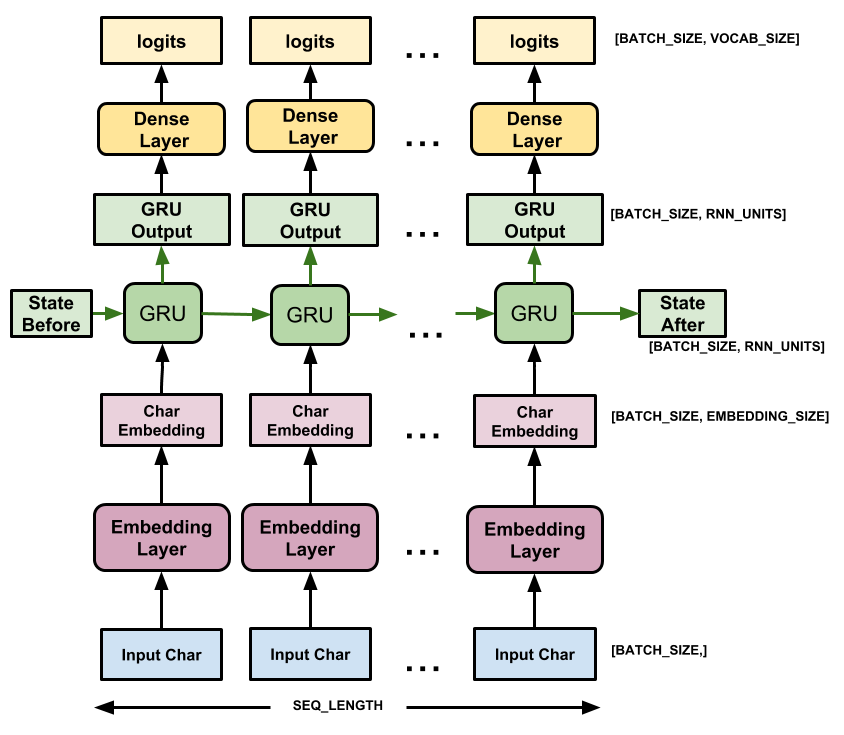

## Try the model before Training

Now run the model to see that it behaves as expected.

First check the shape of the output:

In [29]:
print(dataset.take(1))

for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


<TakeDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>
(64, 100, 65) # (batch_size, sequence_length, vocab_size)


In the above example the sequence length of the input is `100` but the model can be run on inputs of any length:

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (64, None, 256)           16640     
_________________________________________________________________
gru_1 (GRU)                  (64, None, 1024)          3938304   
_________________________________________________________________
dense_1 (Dense)              (64, None, 65)            66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

**Note: It is important to _sample_ from this distribution as taking the _argmax_ of the distribution can easily get the model stuck in a loop.**

Try it for the first example in the batch:

In [34]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()    
# tf.random.categorical: draws samples from a categorical distribution. Uses random sampling but not fully random but following the probability distribution form the categorical logit.
# tf.squeeze: Given a tensor `input`, this operation returns a tensor of the same type with all dimensions of size 1 removed. If you don't want to remove all size 1 dimensions, you can remove specific size 1 dimensions by specifying `axis`.


# This gives us, at each timestep, a prediction of the next character index:

print(sampled_indices)


# Decode these to see the text predicted by this untrained model:

print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

[43 60 50  0 56 12  0 56 53  2 12 42 63 49 21  2 22 47 36 21 49 57  7 60
 15 41 50  9  9 53 18 47 37 16 28 20 35 35 21 14 28 12 45 64 17  2 58 42
 12 47 48 48 60 42 34 22 40 62 50 24 44  2  9 57 64 23 50 47 36  2  3 34
 12 30 34 58 44 15  7 62 12 30  8 13 41  4 54  3 30 30  7  5 24 52 52 27
 39 22 55 48]
Input: 
 'that I may minister\nTo them accordingly.\n\nProvost:\nI would do more than that, if more were needful.\n'

Next Char Predictions: 
 "evl\nr?\nro!?dykI!JiXIks-vCcl33oFiYDPHWWIBP?gzE!td?ijjvdVJbxlLf!3szKliX!$V?RVtfC-x?R.Ac&p$RR-'LnnOaJqj"


## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

The standard `tf.keras.losses.sparse_categorical_crossentropy` loss function works in this case because it is applied across the last dimension of the predictions.

Because our model returns logits, we need to set the `from_logits` flag.


In [35]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.174066


Configure the training procedure using the `tf.keras.Model.compile` method. We'll use `tf.keras.optimizers.Adam` with default arguments and the loss function.

In [0]:
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

### Configure checkpoints

Use a `tf.keras.callbacks.ModelCheckpoint` to ensure that checkpoints are saved during training:

In [0]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

### Execute the training

To keep training time reasonable, use 10 epochs to train the model. In Colab, set the runtime to GPU for faster training.

In [40]:
EPOCHS=30

history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/30
172/172 [==============================] - 12s 70ms/step - loss: 1.2161 - accuracy: 0.6235
Epoch 2/30
172/172 [==============================] - 12s 70ms/step - loss: 1.1839 - accuracy: 0.6329
Epoch 3/30
172/172 [==============================] - 12s 71ms/step - loss: 1.1513 - accuracy: 0.6426
Epoch 4/30
172/172 [==============================] - 12s 71ms/step - loss: 1.1182 - accuracy: 0.6527
Epoch 5/30
172/172 [==============================] - 12s 71ms/step - loss: 1.0831 - accuracy: 0.6634
Epoch 6/30
172/172 [==============================] - 12s 71ms/step - loss: 1.0493 - accuracy: 0.6746
Epoch 7/30
172/172 [==============================] - 12s 71ms/step - loss: 1.0123 - accuracy: 0.6871
Epoch 8/30
172/172 [==============================] - 12s 71ms/step - loss: 0.9761 - accuracy: 0.6997
Epoch 9/30
172/172 [==============================] - 12s 71ms/step - loss: 0.9411 - accuracy: 0.7113
Epoch 10/30
172/172 [==============================] - 12s 71ms/step - loss: 0.907

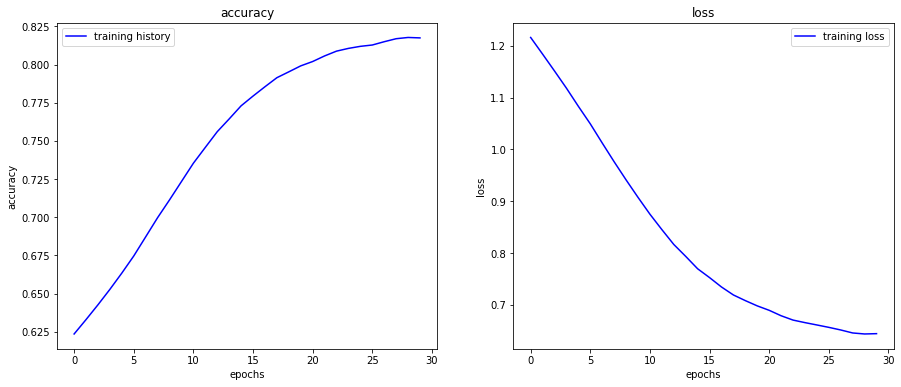

In [45]:
acc = history.history['accuracy']
loss = history.history['loss']


plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(acc, 'b', label='training history')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, 'b', label='training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss')
plt.legend()

plt.show()


## Generate text

### Restore the latest checkpoint

To keep this prediction step simple, **use a batch size of 1.**

** Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built. **

**To run the model with a different `batch_size`, we need to rebuild the model and restore the weights from the checkpoint.  **

In [46]:
# Restore the checkpoint weights so we can change the batch_size
tf.train.latest_checkpoint(checkpoint_dir)


model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))


model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
gru_2 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_2 (Dense)              (1, None, 65)             66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


### The prediction loop

The following code block generates the text:

* It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

* Get the prediction distribution of the next character using the start string and the RNN state.

* Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

* The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.


![To generate text the model's output is fed back to the input](images/text_generation_sampling.png)

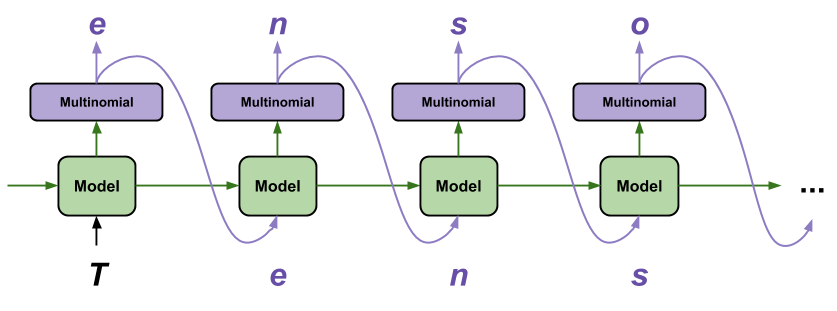

Looking at the generated text, you'll see the model knows when to capitalize, make paragraphs and imitates a Shakespeare-like writing vocabulary. With the small number of training epochs, it has not yet learned to form coherent sentences.

In [0]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 1000

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [48]:
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: what says humble staff, but for mine own redage
Than death, no staff, regaided
As you were foreroun'd with brights. He could grow sooth.

MENEY:
Then whither you must
Call all Clarence out of day.

LADY ANNE:
I am for thee in a happy liege;
My father will not be but riddle.

FRIAR LAURENCE:
Let me assist what I was before.

HENRY BOLINGBROKE:
Name thee to fear.

GONZALO:
This gentle countesir, be proud?

ISABELLA:
Pardon: 'tis an irl-warring one and loathsome doth the king
is a lip of hoardive er Rut not another course.

MERCUTIO:
A whould be continent souls Adoilld as are to death, man?

First Watchman:
Ay, but 'tis one that od content:
My Lord of Norfolk, gentle prince, and give them up;
So sanctuary remain about the disinuer, but
with ne'er be seen to our duty.

KING RICHARD III:
Welcome, good Corulicable, when thou hast
Turn'd to their teeth and banish'd usubort?
Put up your daughter too proof; and
then;
I'll plant Plantagenet, Do not; sir! was Aufidius shall I
Hole in my ho

The easiest thing you can do to improve the results it to train it for longer (try `EPOCHS=30`).

You can also experiment with a different start string, or try adding another RNN layer to improve the model's accuracy, or adjusting the temperature parameter to generate more or less random predictions.

## Advanced: Customized Training

The above training procedure is simple, but does not give you much control.

So now that you've seen how to run the model manually let's unpack the training loop, and implement it ourselves. This gives a starting point if, for example, to implement _curriculum learning_ to help stabilize the model's open-loop output.

We will use `tf.GradientTape` to track the gradients. You can learn more about this approach by reading the [eager execution guide](https://www.tensorflow.org/guide/eager).

The procedure works as follows:

* First, initialize the RNN state. We do this by calling the `tf.keras.Model.reset_states` method.

* Next, iterate over the dataset (batch by batch) and calculate the *predictions* associated with each.

* Open a `tf.GradientTape`, and calculate the predictions and loss in that context.

* Calculate the gradients of the loss with respect to the model variables using the `tf.GradientTape.grads` method.

* Finally, take a step downwards by using the optimizer's `tf.train.Optimizer.apply_gradients` method.

In [0]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [0]:
optimizer = tf.keras.optimizers.Adam()

In [0]:
@tf.function
def train_step(inp, target):
  with tf.GradientTape() as tape:
    predictions = model(inp)
    loss = tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(
            target, predictions, from_logits=True))
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss

In [53]:
# Training step
EPOCHS = 30

for epoch in range(EPOCHS):
  start = time.time()

  # initializing the hidden state at the start of every epoch
  # initally hidden is None
  hidden = model.reset_states()

  for (batch_n, (inp, target)) in enumerate(dataset):
    loss = train_step(inp, target)

    if batch_n % 100 == 0:
      template = 'Epoch {} Batch {} Loss {}'
      print(template.format(epoch+1, batch_n, loss))

  # saving (checkpoint) the model every 5 epochs
  if (epoch + 1) % 5 == 0:
    model.save_weights(checkpoint_prefix.format(epoch=epoch))

  print ('Epoch {} Loss {:.4f}'.format(epoch+1, loss))
  print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 1.1630191802978516
Epoch 1 Batch 100 Loss 1.2041949033737183
Epoch 1 Loss 1.2054
Time taken for 1 epoch 12.258207559585571 sec

Epoch 2 Batch 0 Loss 1.1209434270858765
Epoch 2 Batch 100 Loss 1.138725757598877
Epoch 2 Loss 1.2156
Time taken for 1 epoch 12.3597092628479 sec

Epoch 3 Batch 0 Loss 1.0812517404556274
Epoch 3 Batch 100 Loss 1.135270357131958
Epoch 3 Loss 1.1760
Time taken for 1 epoch 12.491119861602783 sec

Epoch 4 Batch 0 Loss 1.0842101573944092
Epoch 4 Batch 100 Loss 1.1245280504226685
Epoch 4 Loss 1.1160
Time taken for 1 epoch 12.47356915473938 sec

Epoch 5 Batch 0 Loss 0.9986855983734131
Epoch 5 Batch 100 Loss 1.1146568059921265
Epoch 5 Loss 1.1315
Time taken for 1 epoch 12.701141595840454 sec

Epoch 6 Batch 0 Loss 0.9885984659194946
Epoch 6 Batch 100 Loss 1.0343220233917236
Epoch 6 Loss 1.0644
Time taken for 1 epoch 12.607579231262207 sec

Epoch 7 Batch 0 Loss 0.9516949653625488
Epoch 7 Batch 100 Loss 1.0001336336135864
Epoch 7 Loss 1.0517
Time take